In [2]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt 
from torchvision import transforms 
from going_modular import data_setup , engine 
from going_modular.helper_function import download_data ,set_seeds, plot_loss_curves

# 1.Get Data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"


[INFO] data/pizza_steak_sushi directory exists, skipping download.


# 2. Create the Dataset and DataLoader

In [3]:
IMG_SIZE = 224 
manual_transforms = transforms.Compose({
    transforms.Resize((IMG_SIZE , IMG_SIZE)),
    transforms.ToTensor()
})
print("Manually creates transforms :{}".format(manual_transforms))


Manually creates transforms :Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
)


In [4]:
BATCH_SIZE = 32
train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(train_dir= train_dir , test_dir= test_dir, transform= manual_transforms , batch_size=BATCH_SIZE )
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb27b1dcdd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb27b38be10>)

In [5]:
class_names

['pizza', 'steak', 'sushi']

In [6]:
image_batch , label_batch = next(iter(train_dataloader))
single_image , single_label = image_batch[0] , label_batch[0]
single_image.shape , class_names[single_label] , single_label

/home/saaho/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/saaho/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be cons

(torch.Size([3, 224, 224]), 'sushi', tensor(2))

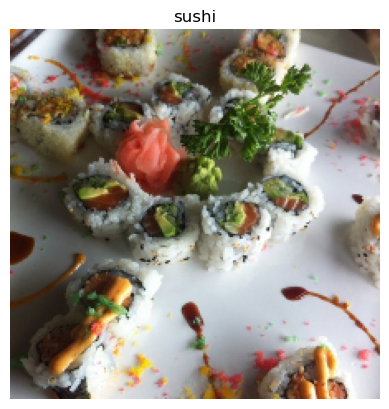

In [7]:
plt.imshow(single_image.permute(1,2,0))
plt.title(class_names[single_label])
plt.axis(False)
plt.show()


# 3.Replicating the ViT paper

# Calculating patch embedding input and output shapes by hand

In [8]:
height = 224 
width = 224 
channel = 3
patch_size = 16 
number_of_batch = int((height * width) / patch_size ** 2)
number_of_batch

196

In [9]:
embedding_layer_input_shape = (height , width , channel)
embedding_layer_output_shape = (number_of_batch , patch_size **2  * channel)
print(f'embeeding layer input shape:{embedding_layer_input_shape}\nembedding layer output shape:{embedding_layer_output_shape}')

embeeding layer input shape:(224, 224, 3)
embedding layer output shape:(196, 768)


# Turning a single image into patche

(-0.5, 223.5, 223.5, -0.5)

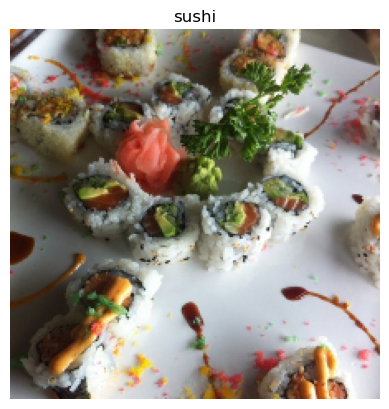

In [10]:
plt.imshow(single_image.permute(1,2,0))
plt.title(class_names[single_label])
plt.axis(False)

In [11]:
single_image.permute(1,2,0).shape

torch.Size([224, 224, 3])

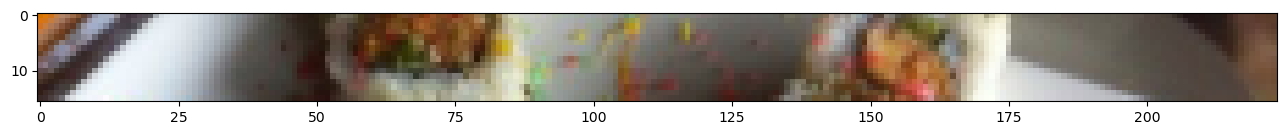

In [12]:
image_permute = single_image.permute(1,2,0)
plt.figure(figsize=(patch_size  ,patch_size))
plt.imshow(image_permute[: patch_size , : , :])


Number of patches per row 14.0 ,
patch size 16 pixel x 16pixel 


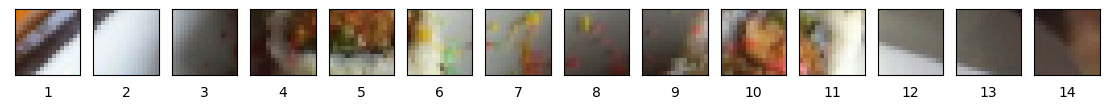

In [13]:
img_size  = 224 
patch_size =  16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divided by the patch size"
print(f"Number of patches per row {num_patches} ,\npatch size {patch_size} pixel x {patch_size}pixel ")
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
for i , patch in enumerate(range(0, img_size , patch_size)):
    axs[i].imshow(image_permute[:patch_size, patch:patch+ patch_size , :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    

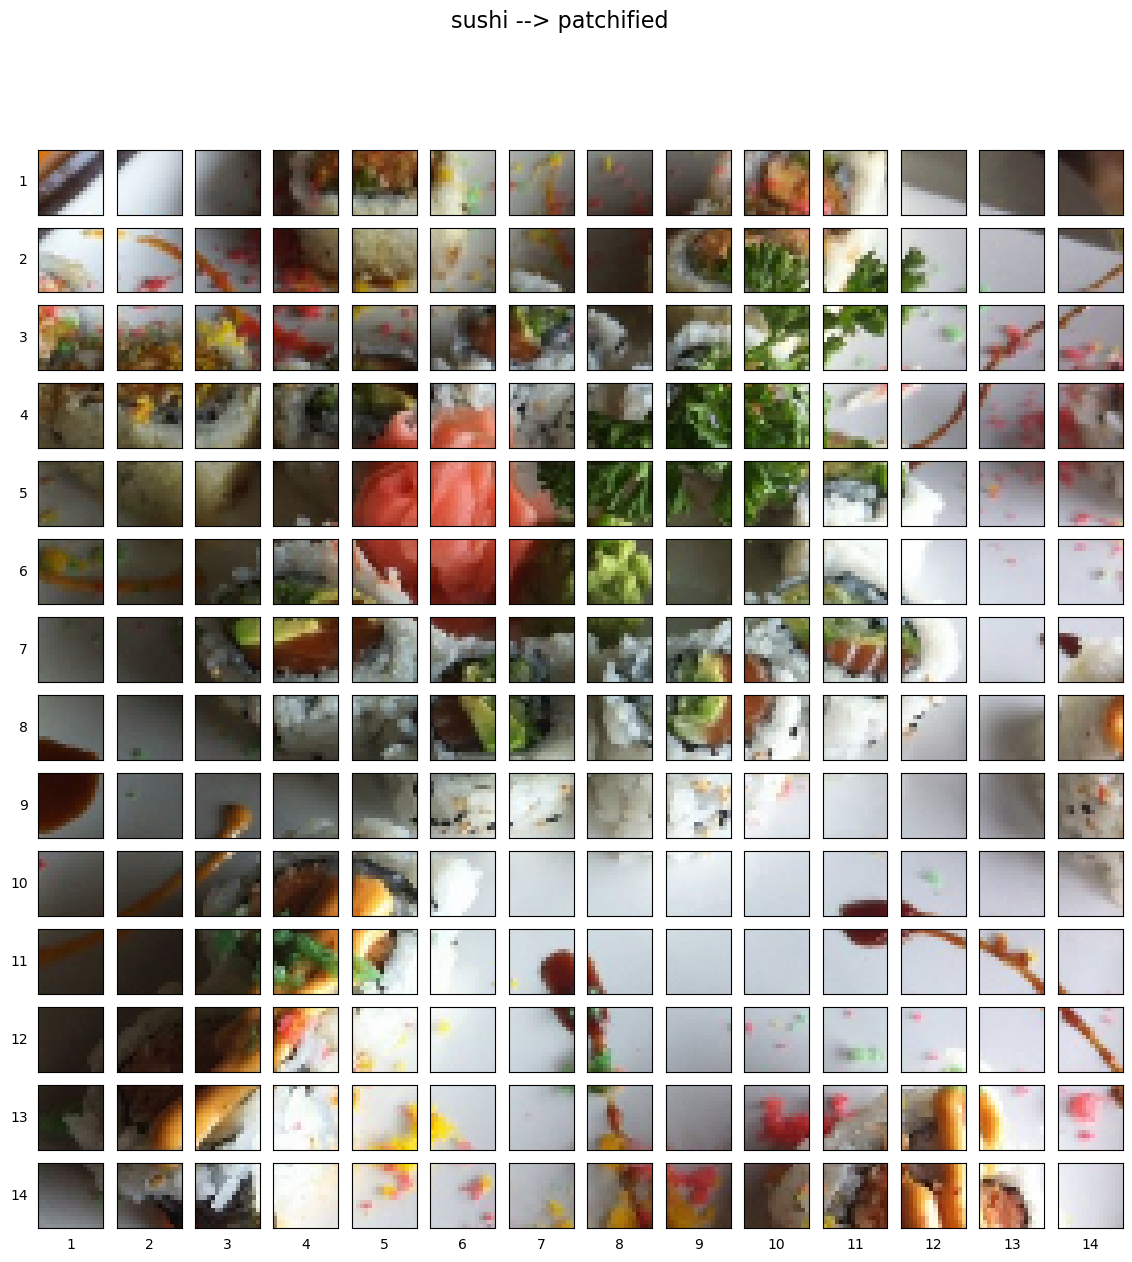

In [14]:
# iterate through the whole image 
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
for i , patch_height in enumerate(range(0 , img_size  , patch_size)):
    for j , patch_width in enumerate(range(0 , img_size , patch_size)):
        axs[i ,j].imshow(image_permute[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i , j].set_xlabel(j+1)
        axs[i ,j].set_ylabel(i+1 , rotation  = 'horizontal' , horizontalalignment  = 'right' , verticalalignment = 'center')
        axs[i , j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i, j].label_outer()


fig.suptitle(f"{class_names[single_label]} --> patchified ", fontsize = 16)
plt.show()

In [15]:
# TO patching using the conv2d layer 
patch_size = 16 
conv2d = torch.nn.Conv2d(in_channels= 3 , out_channels=768, kernel_size= patch_size, stride= patch_size , padding= 0 )


In [16]:
image_out_of_conv = conv2d(single_image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Convolutional feature map


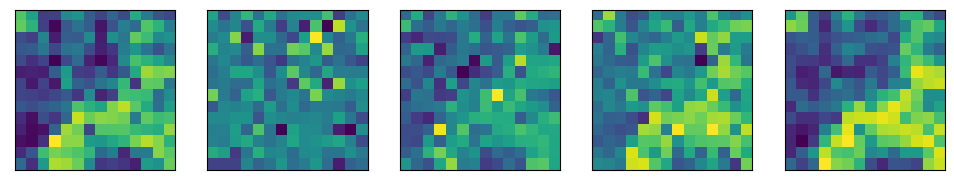

In [17]:
import random 
random_indexes = random.sample(range(0,768) , k=5)
print("Convolutional feature map")
fig , axs = plt.subplots(ncols=5 , nrows=1 , figsize =(12,12))
for i , idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[: , idx , :,:]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);    

In [18]:
single_feature_map = image_out_of_conv[: , 0, :  ,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 0.5158,  0.5711,  0.1388,  0.1482,  0.2077,  0.3332,  0.0624,
            0.0756,  0.1397,  0.0063,  0.4060,  0.4269,  0.2305,  0.0994],
          [ 0.3720,  0.3342,  0.1688, -0.0203,  0.0715,  0.2305,  0.2520,
            0.0467,  0.1210,  0.0968,  0.0582,  0.4588,  0.4732,  0.4705],
          [-0.0441, -0.0505,  0.0374,  0.0697,  0.1207,  0.2356,  0.4473,
            0.2429,  0.1896,  0.2277,  0.4671,  0.5556,  0.3325,  0.2987],
          [ 0.0564,  0.1795,  0.2448,  0.1306,  0.1343,  0.0794,  0.0775,
           -0.1274,  0.0081, -0.0270,  0.2983,  0.2386,  0.1965,  0.2238],
          [ 0.1638, -0.0093,  0.0544,  0.0796, -0.0880, -0.0329,  0.0366,
            0.1919,  0.0081,  0.0430,  0.5405,  0.6071,  0.5382,  0.3673],
          [-0.0101,  0.0615,  0.0450,  0.1706,  0.2143, -0.1304, -0.0091,
           -0.0741,  0.1365,  0.2502,  0.2629,  0.6118,  0.6074,  0.6129],
          [ 0.2052,  0.0932,  0.1427,  0.1760,  0.3431,  0.2175,  0.1372,
            0.3324,  0.2371,  0.

In [19]:
# flatten the spectail dimention 
flatten = torch.nn.Flatten(start_dim= 2 , end_dim= 3)


In [20]:
print(image_out_of_conv.shape)
flatten(image_out_of_conv).shape

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 196])

In [21]:
image_out_of_cov_flatten_reshaped = flatten(image_out_of_conv).permute(0, 2,1)
image_out_of_cov_flatten_reshaped.shape

torch.Size([1, 196, 768])

In [22]:
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels:int = 3, patch_size:int = 16 , embedding_dim :int= 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels= in_channels, out_channels=embedding_dim, kernel_size= patch_size , stride= patch_size, padding= 0)
        self.flatten   = nn.Flatten(start_dim= 2 , end_dim=3)

    def forward(self, x):
            image_resolution = x.shape[-1]
            assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
            x = self.patcher(x)
            x = self.flatten(x)
            return x.permute(0,2,1)



In [23]:
set_seeds()
patchify = PatchEmbedding()
patch_embedding_image = patchify(single_image.unsqueeze(0))
patch_embedding_image.shape

torch.Size([1, 196, 768])

In [24]:
from torchinfo import summary
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#  Creating the class token embedding

In [25]:
patch_embedding_image.shape , patch_embedding_image.requires_grad

(torch.Size([1, 196, 768]), True)

In [26]:
patch_embedding_image.shape[-1]

768

In [27]:
batch_size = patch_embedding_image.shape[0]
embedding_dimention  = patch_embedding_image.shape[-1]
class_tokens = nn.Parameter(torch.ones(batch_size , 1 , embedding_dimention) , requires_grad= True)
print(class_tokens[: ,:, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [28]:
patch_embedded_image_with_class_tokens = torch.cat((class_tokens , patch_embedding_image) , dim=1)
patch_embedded_image_with_class_tokens

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5386,  0.2313, -0.3656,  ...,  0.4508, -0.2180,  0.1538],
         [-0.9788,  0.3265, -0.2934,  ...,  0.6635, -0.2607,  0.3467],
         ...,
         [-0.6065,  0.2526, -0.1049,  ...,  0.2278, -0.4242,  0.3610],
         [-0.8532,  0.1752,  0.0548,  ...,  0.3904, -0.4012,  0.4066],
         [-0.8568,  0.1998, -0.2713,  ...,  0.6711, -0.4109,  0.3624]]],
       grad_fn=<CatBackward0>)

In [29]:
patch_embedded_image_with_class_tokens.shape

torch.Size([1, 197, 768])

In [30]:
patch_embedded_image_with_class_tokens, patch_embedded_image_with_class_tokens.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5386,  0.2313, -0.3656,  ...,  0.4508, -0.2180,  0.1538],
          [-0.9788,  0.3265, -0.2934,  ...,  0.6635, -0.2607,  0.3467],
          ...,
          [-0.6065,  0.2526, -0.1049,  ...,  0.2278, -0.4242,  0.3610],
          [-0.8532,  0.1752,  0.0548,  ...,  0.3904, -0.4012,  0.4066],
          [-0.8568,  0.1998, -0.2713,  ...,  0.6711, -0.4109,  0.3624]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [31]:
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [32]:
embedding_dimention =  patch_embedded_image_with_class_tokens.shape[2]
position_embedding  = nn.Parameter(torch.ones(1, number_of_patches +1  , embedding_dimention), requires_grad= True)
print(position_embedding[:,:,10])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       grad_fn=<SelectBackward0>)


In [33]:
position_embedding.shape

torch.Size([1, 197, 768])

In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_tokens + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [35]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4614, 1.2313, 0.6344,  ..., 1.4508, 0.7820, 1.1538],
         [0.0212, 1.3265, 0.7066,  ..., 1.6635, 0.7393, 1.3467],
         ...,
         [0.3935, 1.2526, 0.8951,  ..., 1.2278, 0.5758, 1.3610],
         [0.1468, 1.1752, 1.0548,  ..., 1.3904, 0.5988, 1.4066],
         [0.1432, 1.1998, 0.7287,  ..., 1.6711, 0.5891, 1.3624]]],
       grad_fn=<AddBackward0>)

#  Multi-Head Attention

In [36]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int = 768 , num_heads:int = 12 , attn_dropout:float = 0):
        super().__init__()
        self.layer_norm  = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn  = nn.MultiheadAttention(embed_dim=embedding_dim , num_heads=num_heads, dropout=attn_dropout , batch_first= True )

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x,  need_weights=False   )
        return  attn_output

In [37]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,  num_heads=12) 
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


#  Multilayer Perceptron (MLP)

In [38]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim:int = 768, mlp_size:int = 3072, dropout:float  = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape= embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features= embedding_dimention,out_features= mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features= embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x ):
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x 

In [39]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# Create the Transformer Encode 

In [40]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embdding_dim:int =768, mlp_size:int = 3072 , mlp_dropout:float = 0.1 ,num_heads:int  = 12, attn_dropout:float = 0  ):
        super().__init__()
        self.mha_block = MultiheadSelfAttentionBlock(num_heads= num_heads , embedding_dim= embdding_dim ,attn_dropout= attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embdding_dim , mlp_size=mlp_size , dropout=mlp_dropout)

    def forward(self, x):
        x = self.mha_block(x) + x
        x = self.mlp_block(x) + x 

        return x 

In [41]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (mha_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [42]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# Putting it all together to create VIT

In [43]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size:int = 224 ,
                 in_channel:int = 3,
                 patch_size:int = 16,
                 num_transformer_layers:int  = 12 , 
                 embedding_dim:int = 768 ,
                 mlp_size:int = 3072 ,
                 num_heads :int = 12 ,
                 attn_dropout:float = 0 ,
                 mlp_dropout:float = 0.1 ,
                 embdding_dropout:float = 0.1 ,
                 num_classes :int = 1000
                 ):
        super().__init__()
        assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
        self.num_patchs = (img_size  * img_size) // patch_size**2 
        self.class_embedding = nn.Parameter(torch.randn(1,1, embedding_dim) , requires_grad= True)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patchs+1 , embedding_dim ) ,requires_grad= True)
        self.embedding_dropout = nn.Dropout(p=embdding_dropout)
        self.patch_embedding = PatchEmbedding(patch_size=patch_size , in_channels= in_channel , embedding_dim= embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embdding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout)  for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape= embedding_dim),
            nn.Linear(in_features= embedding_dim , out_features= num_classes)

            )
        
    def forward(self, x ):
            batch_size = x.shape[0]
            class_tokens = self.class_embedding.expand(batch_size , -1,-1)
            x  = self.patch_embedding(x)
            x = torch.cat((class_tokens , x), dim= 1)
            x = self.position_embedding + x

            x = self.embedding_dropout(x)
            x = self.transformer_encoder(x)
            x = self.classifier(x[:,0])
            return x



In [44]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [45]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [47]:
summary(model= vit, input_size= (32,3,224,224) ,
        col_names = ['input_size','output_size' ,'num_params' , 'trainable'] ,
        col_width= 20,
        row_settings=['var_names']
        , 
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [48]:
optimizer  = torch.optim.Adam(lr=3e-3 , betas=(0.9 ,0.999) ,weight_decay= 0.3, params= vit.parameters())
loss_fn  = nn.CrossEntropyLoss()
set_seeds()
results = engine.train(model= vit, train_dataloader= train_dataloader , test_dataloader= test_dataloader,optimizer=optimizer ,loss_fn= loss_fn , device= device , epochs=2 )

  0%|          | 0/2 [00:00<?, ?it/s]

/home/saaho/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/saaho/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be cons

# Using pretrained ViT models 


In [ ]:
pretrained_vit_model_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_model_weights)
for param in pretrained_vit.parameters():
    param.requires_grad = False 

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)